In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

queens_gas = pd.read_excel('New_DMU.xlsx', sheet_name='QUENGF01')
queens_elec = pd.read_excel('New_DMU.xlsx', sheet_name='QUENEF')
hugh_gas = pd.read_excel('New_DMU.xlsx', sheet_name='HUASGF01')
hugh_elec = pd.read_excel('New_DMU.xlsx', sheet_name='HUASEM')
hawthorn_gas = pd.read_excel('New_DMU.xlsx', sheet_name='HAWTGF01')
hawthorn_elec = pd.read_excel('New_DMU.xlsx', sheet_name='HAWTEMV')

dictionary = {'QG': queens_gas, 'QE': queens_elec, 'HAG': hugh_gas, 'HAE': hugh_elec, 'HTG': hawthorn_gas, 'HTE': hawthorn_elec}

In [2]:
# Model inputs
train_size = 0.3
lookback = 14
df = dictionary['HAG']

In [3]:
## Formating dataframes
# Create year, month, day, and hour columns as well as daily consumption
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%d/%M')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.index = pd.to_datetime(df.index)
#df.drop(['Date'], axis=1, inplace=True)
df['Daily consumption'] = df.iloc[:, 1:-3].sum(axis=1)

In [4]:
df['Daily consumption'][df['Daily consumption'] < 50] = 50

C:\Users\Farshad\AppData\Local\Temp\ipykernel_8988\2824227974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily consumption'][df['Daily consumption'] < 50] = 50


c:\Users\Farshad\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Energy Distribution (kWh)')

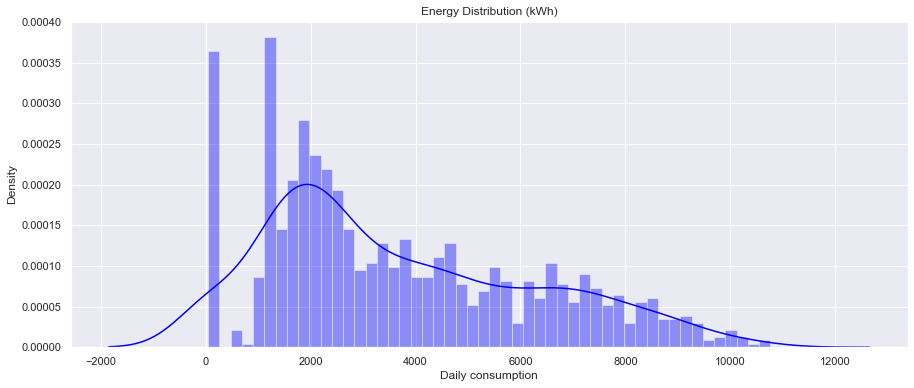

In [5]:
## Visualizing data
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set(rc={'figure.figsize':(15,6)})
sns.distplot(df["Daily consumption"], bins=50, kde=True, color='blue')
plt.title("Energy Distribution (kWh)")

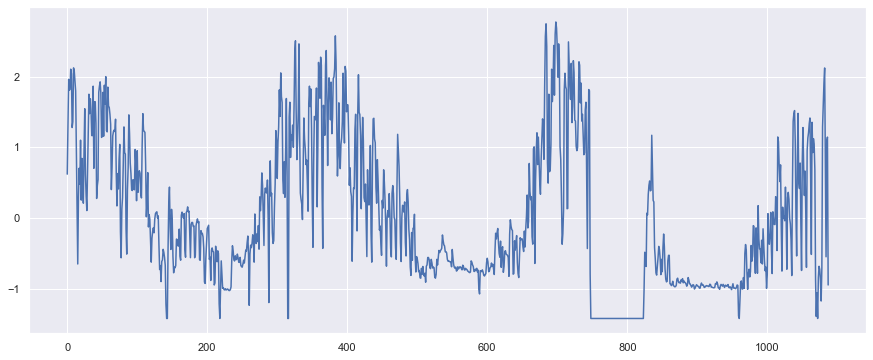

In [6]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
daily_consumption = df["Daily consumption"]
num_train = int(train_size * len(daily_consumption))
daily_consumption_scaled = sc_X.fit_transform(daily_consumption.values.reshape(-1,1))
plt.plot(daily_consumption_scaled)
TestData = daily_consumption_scaled[num_train-lookback:]
Training_Set = daily_consumption_scaled[0:num_train]

In [7]:
# from sklearn.preprocessing import MinMaxScaler
# Training_Set = Training_Set.values
# Training_Set.reshape(1,-1)
# sc = MinMaxScaler(feature_range=(0, 1))
# Train = sc.fit_transform(Training_Set)
# X_Train = np.reshape(Training_Set, newshape=(Training_Set.shape[0], Training_Set.shape[1], 1))
# X_Train.shape
def create_rnn_dataset(data, lookback = 1):
    
    data_x, data_y = [], []
    for i in range(len(data)- lookback - 1):
            #All points from this point, looking backwards upto lookback
            a = data[i:(i+ lookback), 0]
            data_x.append(a)
            #The next point
            data_y.append(data[i + lookback, 0])
    return np.array(data_x), np.array(data_y)

X_Train, Y_Train = create_rnn_dataset(Training_Set, lookback=lookback)

In [8]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], 1, X_Train.shape[1]))
X_Train.shape

(311, 1, 14)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
import tensorflow as tf

tf.random.set_seed(3)

#Create a Keras Model
def create_model(input_shape, output_shape):
    model = Sequential()
    model.add(Dense(units=32, activation='relu', input_shape=input_shape))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(units=1, activation='sigmoid'))
    model.add(Dense(units=output_shape))
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model
ts_model=Sequential()
# #Add LSTM
# ts_model.add(LSTM(64, input_shape=(1,lookback)))
# ts_model.add(Dense(1))

# #Compile with Adam Optimizer. Optimize for minimum mean square error
# ts_model.compile(loss="mean_squared_error",
#                  optimizer="adam",
#                  metrics=["mse"])


ts_model = create_model(input_shape=(1,lookback), output_shape=1)
# #Print model summary
ts_model.summary()


#Train the model
ts_model.fit(X_Train, Y_Train, 
             epochs=5, batch_size=1, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1, 32)             480       
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             24832     
                                                                 
 dense_7 (Dense)             (None, 1, 1)              65        
                                                                 
 dense_8 (Dense)             (None, 1, 1)              2         
                                                                 
Total params: 25,379
Trainable params: 25,379
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
311/311 [==============================] - 2s 1ms/step - loss: 0.6935 - mse: 0.6935
Epoch 2/5
311/311 [==============================] - 0s 1ms/step - loss: 0.4457 - mse: 0

In [13]:
#Preprocess the test dataset, the same way training set is processed
test_req_x, test_req_y = create_rnn_dataset(TestData,lookback)
test_req_x = np.reshape(test_req_x, 
                         (test_req_x.shape[0],1, test_req_x.shape[1]))

#Evaluate the model
ts_model.evaluate(test_req_x, test_req_y, verbose=1)

#Predict for the training dataset
predict_on_train= ts_model.predict(X_Train)
#Predict on the test dataset
predict_on_test = ts_model.predict(test_req_x)

#Inverse the scaling to view results
predict_on_train = sc_X.inverse_transform(predict_on_train)
predict_on_test = sc_X.inverse_transform(predict_on_test)

24/24 [==============================] - 0s 2ms/step - loss: 0.5658 - mse: 0.5658


ValueError: Found array with dim 3. StandardScaler expected <= 2.

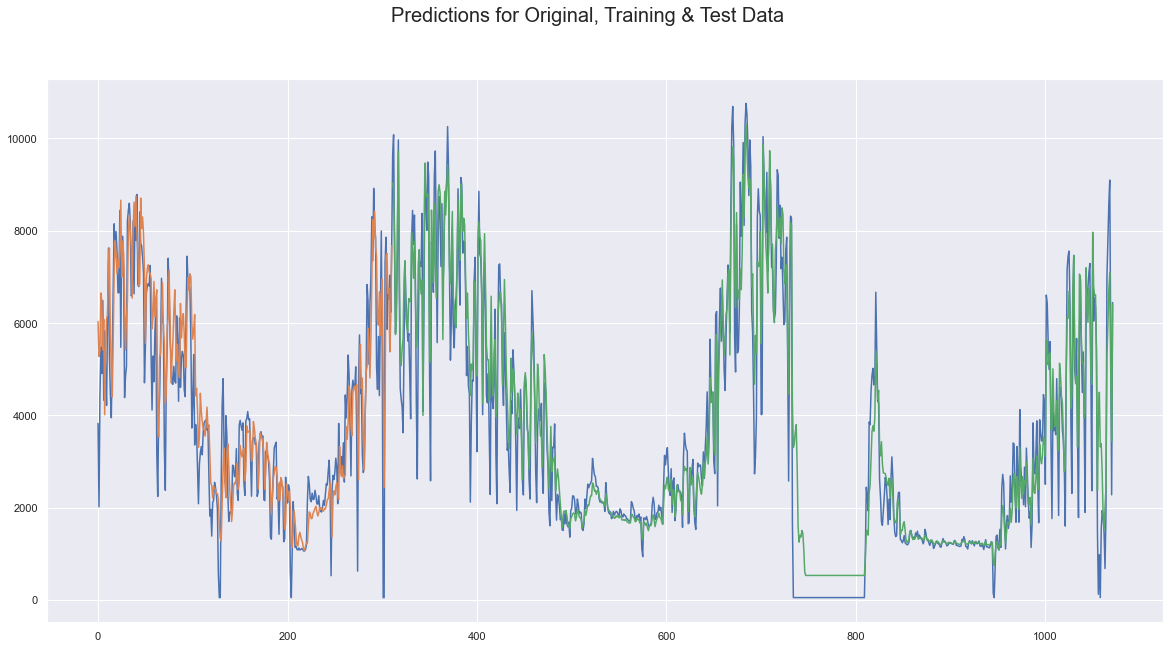

In [ ]:
#Plot the predictions

#Total size of plot
total_size = len(predict_on_train) + len(predict_on_test)

#Plot original data
orig_data = daily_consumption.to_numpy()
orig_data = orig_data.reshape(len(orig_data),1)

#Create a plot for original data
orig_plot = np.empty((total_size,1))
orig_plot[:, :] = np.nan
orig_plot[0:total_size, :] = orig_data[lookback:-2,]

#Create a plot for predictions on training
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

#Create a plot for predictions on testing
predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):total_size, :] = predict_on_test

#Plot the graphs
plotrange = np.arange(0,total_size,1)
plt.figure(figsize=(20,10)).suptitle("Predictions for Original, Training & Test Data", fontsize=20)
plt.plot(orig_plot[plotrange])
plt.plot(predict_train_plot[plotrange])
plt.plot(predict_test_plot[plotrange])
plt.show()

In [ ]:
print(ts_model.layers[0].weights)
print(ts_model.layers[0].bias_initializer)

[<tf.Variable 'lstm_24/lstm_cell_24/kernel:0' shape=(14, 256) dtype=float32, numpy=
array([[-0.09005087,  0.01495141, -0.07240666, ...,  0.08653434,
        -0.07289139, -0.02658018],
       [-0.05684978, -0.00307809,  0.07100771, ..., -0.13453959,
         0.06416684, -0.12130266],
       [-0.04537237,  0.07587369, -0.06059153, ...,  0.14130186,
         0.05457661,  0.05057489],
       ...,
       [ 0.07827219,  0.06927667,  0.03560755, ...,  0.05502117,
        -0.07597136,  0.10636708],
       [ 0.1663561 , -0.23439516,  0.02494615, ..., -0.00046369,
        -0.19748811,  0.04095298],
       [-0.00628864,  0.11872447, -0.11611142, ...,  0.0025127 ,
         0.04577843,  0.030532  ]], dtype=float32)>, <tf.Variable 'lstm_24/lstm_cell_24/recurrent_kernel:0' shape=(64, 256) dtype=float32, numpy=
array([[ 0.09973967, -0.00793022,  0.01313064, ...,  0.04831069,
        -0.06607968,  0.03448936],
       [ 0.04288845, -0.0917002 ,  0.01993332, ..., -0.013426  ,
         0.10441044,  0.0255